## Rockstars or Flop-stars? Examining Recruit Star Rating and NFL Draft Success

by Walker Blackston, MSPH

College football recruiting is quickly becoming a **billion-dollar** business. Since the [NCAA's ruling](https://www.ncaa.org/news/2021/6/30/ncaa-adopts-interim-name-image-and-likeness-policy.aspx) in the summer of 2021, there's been an explosion of valuations and incentives for young men and women across the country to trade their name, image and likeness for brand advertising. Schools and alumni associations can also band together to form "collectives," which can offer NIL contracts to student-athletes as long as the individual is not bound to the school and the school does not sanction the donation. 

It may sound technical, but this landscape is anything but straightforward. It remains a veritable wild west of evaluating and recruiting talent. Many argue that this is no different than prior recruiting standards - allowing outright donations to players without even the slightest guise of "clean" recruitment. But it is this landscape that is also allowing 17 year old boys to be driving Lamborghinis to prom while wearing the same shoes as Lebron James. It could also be exposing gaps in our ability to *evaluate high-school talent.* After all, if you paid a cool $1.5 million for a new quarterback, you'd love a (statistical) certainty that they will produce for your school and even go on to represent them in the NFL. 

**Taken together, this raises several important questions:** 
1) Are the current methods of evaluating recruit potential (i.e. stars none-5) valuable in predicting future success?
2) Are the top programs truly better than the rest of the pack in developing this talent? 

But can we trust agency-touted ratings of these players anyway...? 

**We wish to examine how well star-rating translates to NFL draft success, defined as having your number called in the first, second or third rounds.**

To do so, we will lean on the nice folks at [collegefootballdata.com](https://blog.collegefootballdata.com/) who have graciously created an open-source API to get your hands on very clean data to answer all of your CFB nerd questions. 

In [1]:
pip install cfbd --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.2/348.2 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 29.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pythonwhat 2.23.1 requires asttokens~=1.1.10, but you have asttokens 2.0.8 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.5.1 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.1.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cfbd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import plotly.graph_objects as go
import seaborn as sns
import math
import time
from __future__ import print_function
from cfbd.rest import ApiException
from pprint import pprint

In [3]:
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'QWYHUYDzAZeL8m+sWHvTMOVWEvL/xPJeI9wTNdI6+TG084QBruYHpnNuiHHiRDKL'
configuration.api_key_prefix['Authorization'] = 'Bearer'

api_config = cfbd.ApiClient(configuration)
recruit_api = cfbd.RecruitingApi(api_config)

In [4]:
recruit = []

for year in range(2006, 2022):
    response = recruit_api.get_recruiting_players(year=year)
    recruit = [*recruit, *response]


recruit_df = pd.DataFrame().from_records([
                dict(ident = r.id, 
                     rank = r.ranking, 
                     name = r.name, 
                     year = r.year, 
                     rating=r.rating, 
                     stars=r.stars, 
                     position=r.position, 
                     commit = r.committed_to)
                for r in recruit
                if r.ranking is not None
                    and r.name is not None
                    and r.year is not None
                    and r.rating is not None
            ])


recruit_df.tail()

,ident,rank,name,year,rating,stars,position,commit
51294,74091,2712,Britton Williams,2021,0.7530,2,K,Georgia Southern
51295,75815,2713,Zach Zoglio,2021,0.7530,2,LS,Eastern Michigan
51296,75816,2714,Tanner Luther,2021,0.7530,2,K,Eastern Michigan
51297,74092,2715,Jabril Williams,2021,0.7491,2,ATH,Army
51298,75361,2716,Elisha Cummings,2021,0.7441,2,RB,Idaho


In [5]:
recruit_df.head()

,ident,rank,name,year,rating,stars,position,commit
0,8263,1,Andre Smith,2006,0.9993,5,OG,Alabama
1,8264,2,Percy Harvin,2006,0.9989,5,WR,Florida
2,8265,3,Vidal Hazelton,2006,0.9984,5,WR,USC
3,8266,4,Sergio Kindle,2006,0.9980,5,ILB,Texas
4,8267,5,Myron Rolle,2006,0.9977,5,S,Florida State


Looks like we have our recruiting data in decent shape. Better yet, we queried all data from as far back as we have Rivals/ESPN ratings on recruits. But let's explore these data with some more granularity. How many recruits are we analyzing from '06 to '22? 

In [6]:
len(recruit_df)

51299

At 50k+ recruits, we can be confident to have enough data to adequately split and train a decent model. But no guarantees. We still need to clean and import some more data before examining draft success. Let's also play around with these data and break down yearly, school and positional differences: 

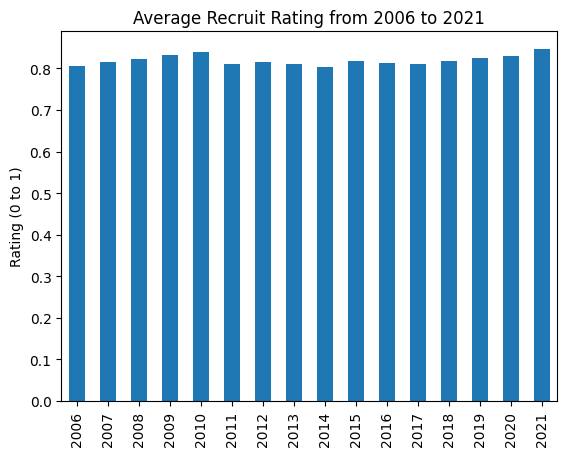

In [7]:
#plotting various strata of recruit rankings
fig, ax = plt.subplots()

recruit_df.groupby('year')['rating'].mean().plot.bar(ax=ax, legend = False)
ax.set_ylabel("Rating (0 to 1)")
ax.set_xlabel('')

plt.title('Average Recruit Rating from 2006 to 2021')
plt.show()

Not *too* much variation by year, so we can rule that out as a potentially confounding variable to consider. We want more or less the same baseline of recruit ratings to consider each year. 
What about schools who land the lion's share of highly rated recruits? 

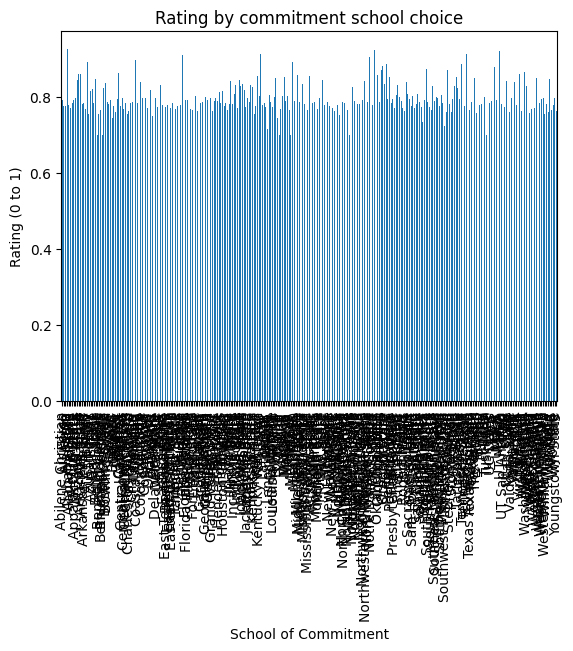

In [8]:
fig, ax = plt.subplots()

recruit_df.groupby('commit')['rating'].mean().plot.bar(ax = ax, legend = False)
ax.set_ylabel("Rating (0 to 1)")
ax.set_xlabel('School of Commitment')

plt.title('Rating by commitment school choice')
plt.show()

Pretty darn messy. Maybe we ought to restrict recruit composite ratings to just those considered "elite" (0.80 or greater). 

In [9]:
#filter data by rating >= 0.90
high_rate_recruits = recruit_df[recruit_df['rating'] >= 0.90]
high_rate_recruits.head()

,ident,rank,name,year,rating,stars,position,commit
0,8263,1,Andre Smith,2006,0.9993,5,OG,Alabama
1,8264,2,Percy Harvin,2006,0.9989,5,WR,Florida
2,8265,3,Vidal Hazelton,2006,0.9984,5,WR,USC
3,8266,4,Sergio Kindle,2006,0.9980,5,ILB,Texas
4,8267,5,Myron Rolle,2006,0.9977,5,S,Florida State


In [10]:
print('From 2006 to 2022, there were ' + str(len(high_rate_recruits)) + ' recruits with composite rankings greater than or equal to 0.90 signed.')

From 2006 to 2022, there were 4455 recruits with composite rankings greater than or equal to 0.90 signed.


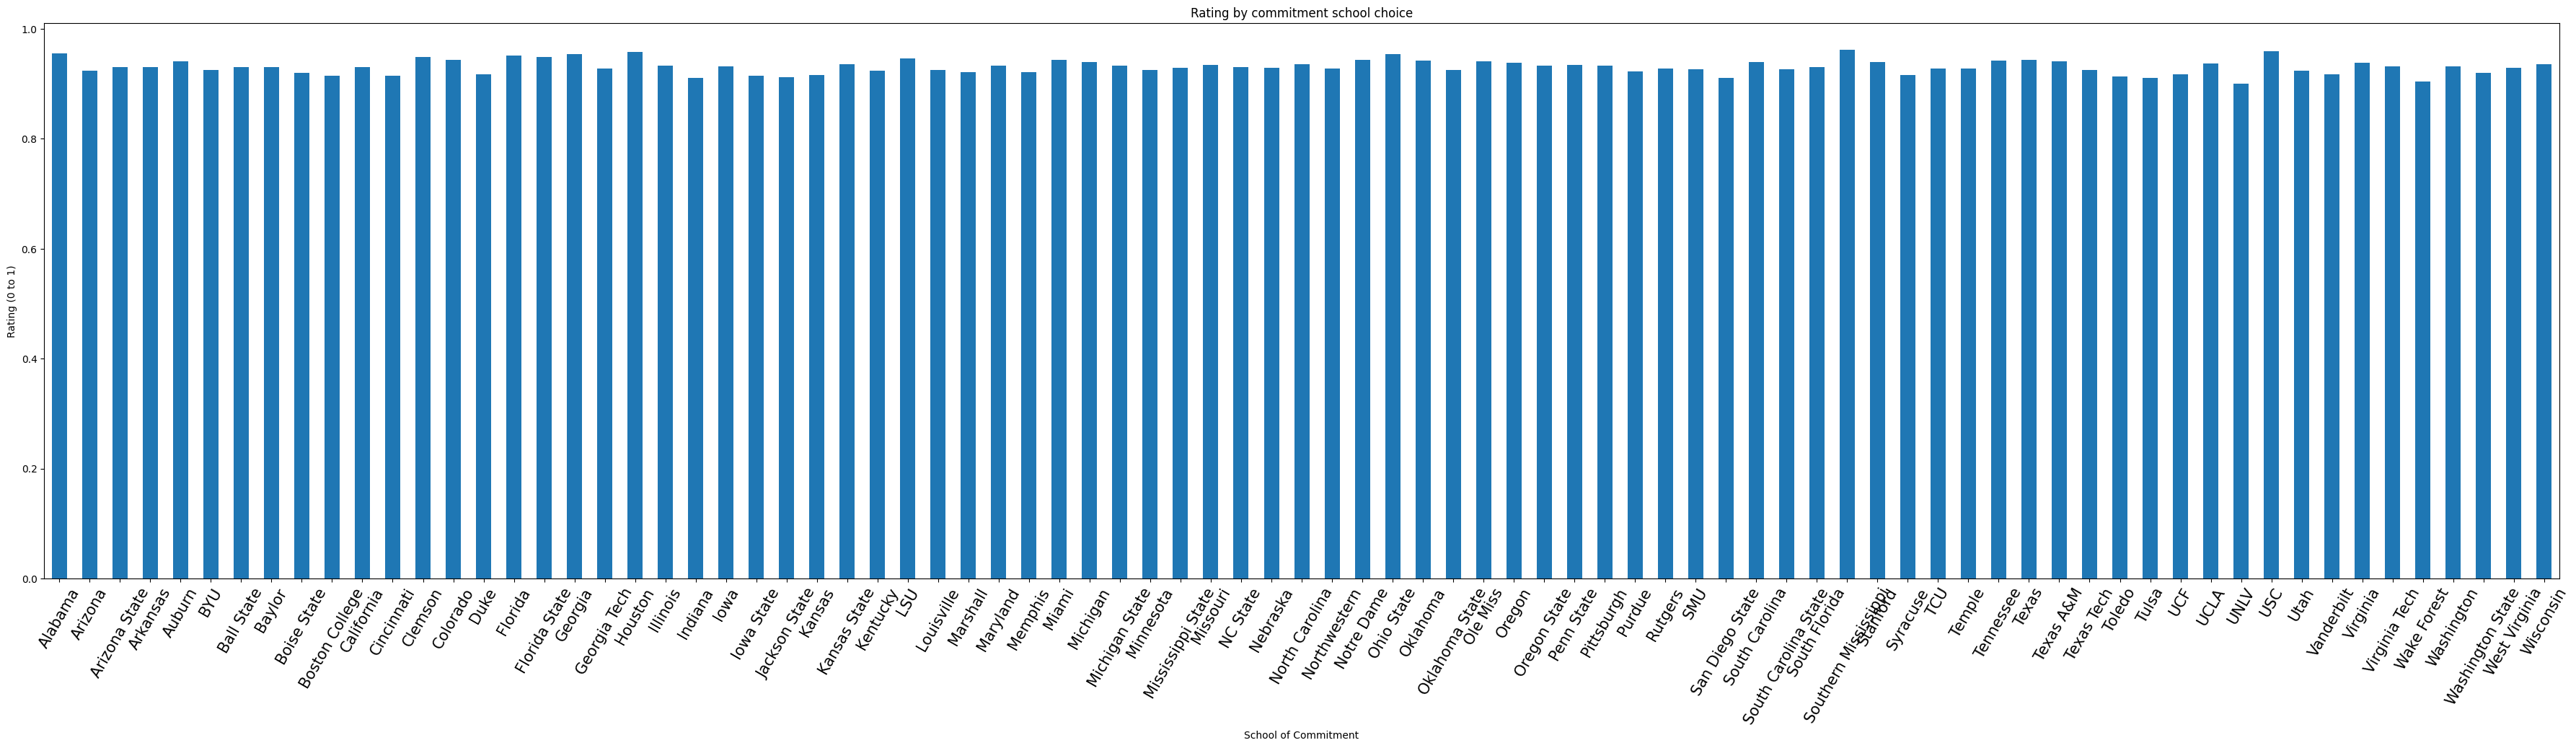

In [11]:
fig, ax = plt.subplots(figsize=(45,10))

high_rate_recruits.groupby('commit')['rating'].mean().plot.bar(ax = ax, legend = False)
ax.set_ylabel("Rating (0 to 1)")
ax.set_xlabel('School of Commitment')

plt.title('Rating by commitment school choice')
ax.xaxis.set_tick_params(labelsize=15, rotation = 60)
plt.show()

So it appears, at least graphically, that not a whole lot separates what most label as elite programs from non-elite programs. There are some spikes with Alabama, Florida, Ohio State etc., but remember this is also averaged out over the past 16 years - programs wax and wane in that time (even 'Bama since this gives us 3 years pre-Saban era). Maybe we could look with even more granularity by asking who signs the most 4 and 5 stars *only.* 

In [12]:
four_five_stars = recruit_df[(recruit_df['stars'] >= 4)]
print('From 2006 to 2022, there were ' + str(len(four_five_stars)) + ' 4 or 5 star recruits signed.')

From 2006 to 2022, there were 5443 4 or 5 star recruits signed.


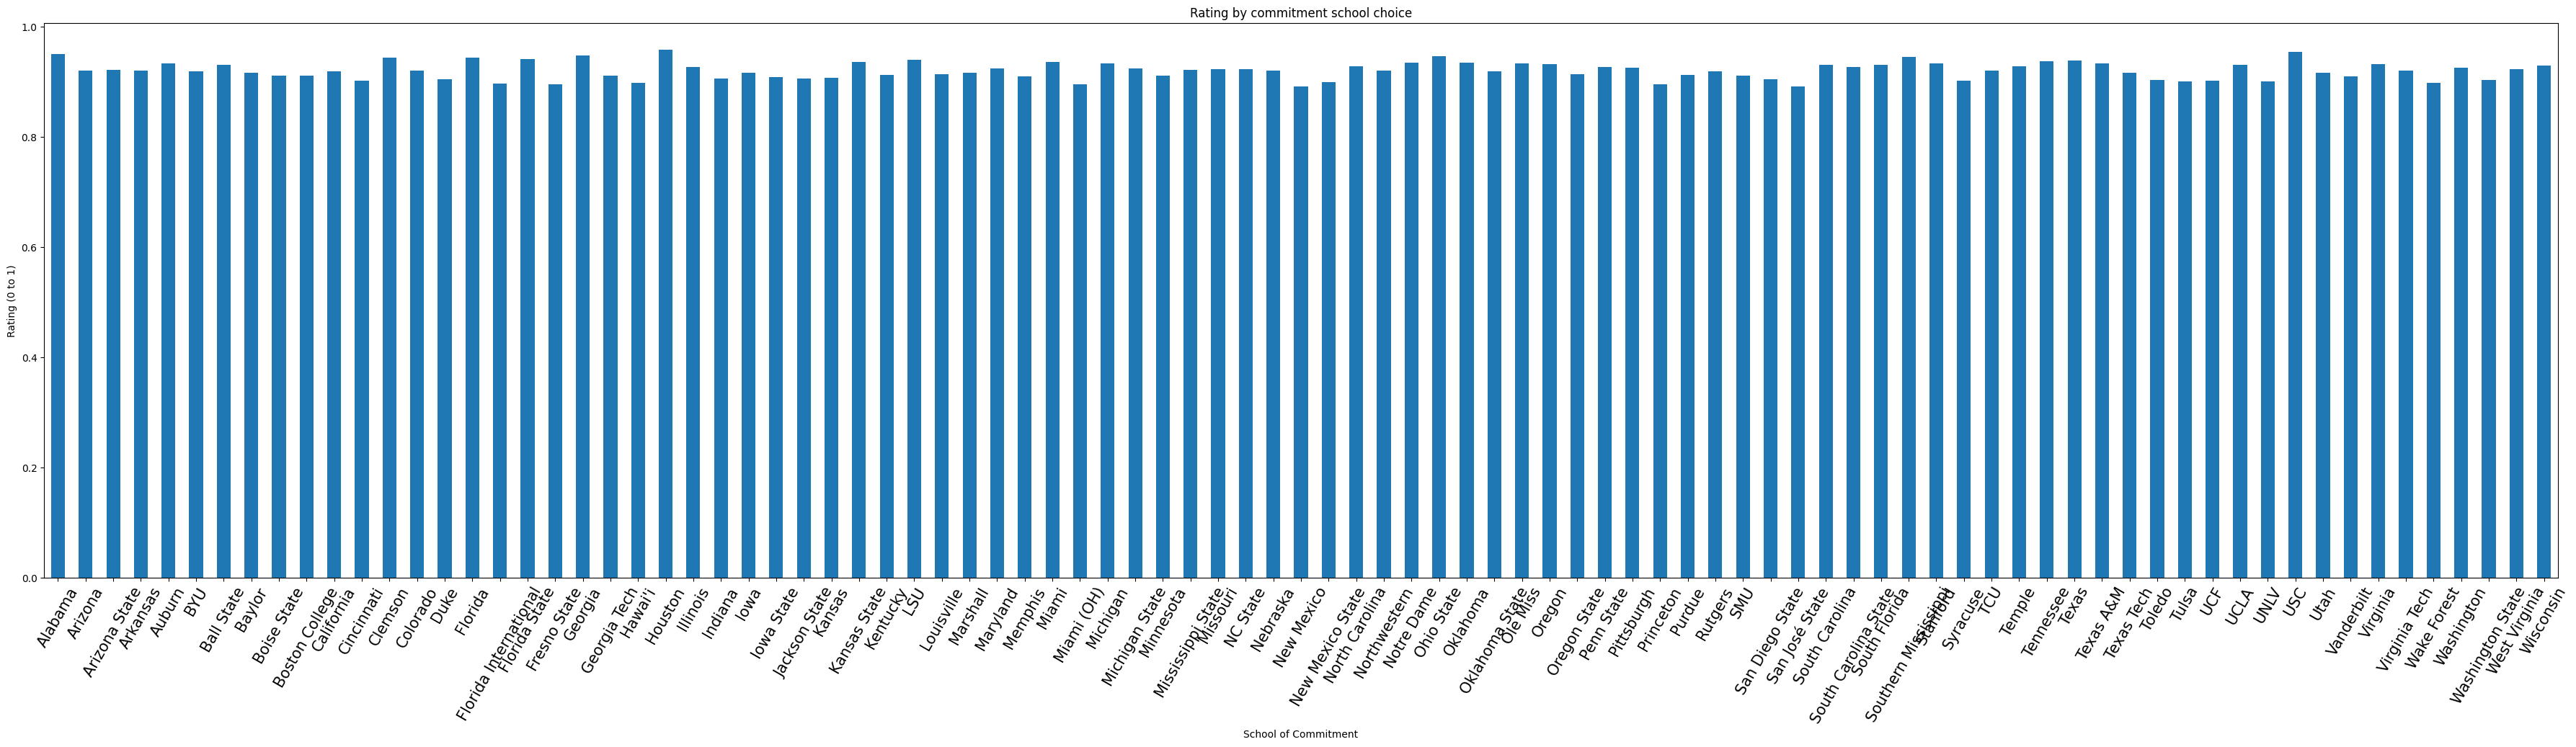

In [13]:
fig, ax = plt.subplots(figsize=(45,10))

four_five_stars.groupby('commit')['rating'].mean().plot.bar(ax = ax, legend = False)
ax.set_ylabel("Rating (0 to 1)")
ax.set_xlabel('School of Commitment')

plt.title('Rating by commitment school choice')
ax.xaxis.set_tick_params(labelsize=15, rotation = 60)
plt.show()

### ***Bring in draft data:***

In [15]:
draft_api = cfbd.DraftApi(api_config)
draft = []

for year in range(2006, 2022):
    response = draft_api.get_draft_picks(year=year)
    draft = [*draft, *response]


draft_df = pd.DataFrame().from_records([
                dict(college = p.collegeTeam,
                     draft_grade = p.preDraftGrade, 
                     name = p.name, 
                     year = p.year, 
                     overall=p.overall, 
                     d_round = p.round,
                     pick = p.pick,
                     position=p.position, 
                     )
                for p in draft
                if p.pick is not None
                    and p.name is not None
                    and p.year is not None
                    and p.position is not None
            ])


draft_df.tail()

AttributeError: 'DraftPick' object has no attribute 'collegeTeam'

#### ***Adapting code from Bill's ANN to build own prediction model for Draft success***

In [11]:
pip install fastai --upgrade

In [12]:
from fastai.tabular import *
from fastai.tabular.all import *

In [ ]:
teams_api = cfbd.TeamsApi(api_config)
ratings_api = cfbd.RatingsApi(api_config)
games_api = cfbd.GamesApi(api_config)
stats_api = cfbd.StatsApi(api_config)
betting_api = cfbd.BettingApi(api_config)

If you have any comments or suggestions, I am always looking to improve and collaborate. Please feel free to email me at <stats@walkerblackston.com>